## [Description](#Description_)
## [Todo](#Todo_)
## [Research](#Research_)
## [Imports](#Imports_)
## [Globals](#Globals_)
## [Setup](#Setup_)
## [Data](#Data_)
### - [Annotation structure](#Annotation_structure_)
### - [Data exploration](#Data_exploration_)
### - [Data splits](#Data_splits_)
### - [Prediction target](#Prediction_target_)
### - [Dataset](#Dataset_)
## [Model](#Model_)
### - [Add task specific tokens](#Add_task_specific_tokens_)
### - [Add dataset specific tokens](#Add_dataset_specific_tokens_)
### - [Dataloader](#Dataloader_)
### - [Lightning module](#Lightning_module_)
## [Training](#Training_)
## [Results](#Results_)

## Description <span id=Description_></span>

Trying my hand at this kaggle challenge:

https://www.kaggle.com/competitions/benetech-making-graphs-accessible

## Todo <span id=Todo_></span>

- Make sure that padding tokens are ignored in loss
- Check out dataset https://chartinfo.github.io/toolsanddata.html
- Try ready models as baselines:
    - https://www.kaggle.com/competitions/benetech-making-graphs-accessible/code
    - https://github.com/huggingface/pytorch-image-models
- Try segmentation -> classification -> parsing pipeline
- For inference, check out https://pytorch.org/serve/

## Research <span id=Research_></span>

[Donut](https://arxiv.org/pdf/2111.15664.pdf) - document understanding transformer without the intermediate optical character recognition step.
[Example notebook one](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/Donut/CORD/Fine_tune_Donut_on_a_custom_dataset_(CORD)_with_PyTorch_Lightning.ipynb),
[example notebook two](https://www.kaggle.com/code/nbroad/donut-train-benetech).

## Imports <span id=Imports_></span>

In [260]:
%load_ext nb_black
%matplotlib inline


import collections
import dataclasses
import datasets
import einops
import enum
import glob
import IPython
import imageio
import json
import functools
import matplotlib.animation
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pprint
import pytorch_lightning as pl
import reprlib
import torch
import torchvision
import tqdm.autonotebook
import transformers
import types
from typing import Literal

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

## Globals <span id=Globals_></span>

In [2]:
COMPETITION = "benetech-making-graphs-accessible"
DEBUG: bool = True
DATA = types.SimpleNamespace()
TOKEN = types.SimpleNamespace()
CONFIG = types.SimpleNamespace()
MODEL = types.SimpleNamespace()

<IPython.core.display.Javascript object>

## Setup <span id=Setup_></span>

### Markdown

In [3]:
def make_new_markdown_section_with_link(section, header="##", do_print=True):
    section_id = section.replace(" ", "_") + "_"
    section_link = f"{header} [{section}](#{section_id})"
    section_header = f"{header} {section} <span id={section_id}></span>"
    if do_print:
        print(section_link + "\n" + section_header)
    return section_link, section_header


def make_several_sections(
    section_names=(
        "Description",
        "Imports",
        "Globals",
        "Setup",
        "Data",
        "Data exploration",
        "Model",
        "Training",
        "Results",
    )
):
    links, headers = zip(
        *[
            make_new_markdown_section_with_link(sn, do_print=False)
            for sn in section_names
        ]
    )
    print("\n".join(links + ("",) + headers))

<IPython.core.display.Javascript object>

### Terminal

In [4]:
def mkdir(path, error_if_exists=False):
    !mkdir {"-p" if not error_if_exists else ""} {path}


def unzip(zip_path, save_path=None, delete_zip=False):
    !unzip {zip_path} {"-d "+ save_path if save_path else ""}
    if delete_zip:
        for path in glob.glob(zip_path):
            if path.endswith(".zip"):
                !trash {path}


def unzip_to_data_and_delete():
    unzip("data/*", "data", delete_zip=True)

<IPython.core.display.Javascript object>

### Kaggle

In [5]:
def kaggle_competitions_search(search_term):
    !kaggle competitions list -s {search_term}


def kaggle_competitions_files(competition):
    !kaggle competitions files {competition}


def kaggle_competitions_download(competition, save_path="data", filename=None):
    mkdir(save_path)
    !kaggle competitions download -p {save_path} {"-f " + filename if filename else ""} {competition}


def kaggle_competitions_submit(competition, filename, message="submit"):
    !kaggle competitions submit -f {filename} -m {message} {competition}


def kaggle_competitions_submissions(competition):
    !kaggle competitions submissions {competition}

<IPython.core.display.Javascript object>

## Data <span id=Data_></span>

In [6]:
if not os.path.exists("data"):
    kaggle_competitions_download(COMPETITION)
    unzip_to_data_and_delete()

<IPython.core.display.Javascript object>

In [7]:
def path_to_dict(path, print_only_last_dirname=False):
    dirpath, dirnames, filenames = next(os.walk(path))
    path_contents = filenames

    for dirname in dirnames:
        full_dirname = os.path.join(path, dirname)
        path_contents.append(path_to_dict(full_dirname, print_only_last_dirname=True))

    if print_only_last_dirname:
        path = os.path.split(path)[-1]

    return {path: path_contents}


def pprint_path_contents(path):
    path_dict = path_to_dict(path)
    short_path_repr = reprlib.repr(path_dict)
    short_path_dict = eval(short_path_repr)
    string = pprint.pformat(short_path_dict).replace("Ellipsis", "...")
    print(string)

<IPython.core.display.Javascript object>

In [8]:
pprint_path_contents("data")

{'data': ['sample_submission.csv',
          {'train': [{'images': ['52ecbd029a07.jpg',
                                 'fd7e3f0e4d43.jpg',
                                 'f0122da6cbe1.jpg',
                                 '2a186a0fa1ae.jpg',
                                 '6559c7a7d153.jpg',
                                 '5fd880333d07.jpg',
                                 ...]},
                     {'annotations': ['0f4f52fc3f4b.json',
                                      '35f0ec146509.json',
                                      '2e374a37e404.json',
                                      '96578b79c571.json',
                                      'dfbd6e21c301.json',
                                      '0893be463049.json',
                                      ...]}]},
          {'test': [{'images': ['000b92c3b098.jpg',
                                '01b45b831589.jpg',
                                '00dcf883a459.jpg',
                                '007a18eb4e09.jpg'

<IPython.core.display.Javascript object>

In [9]:
@functools.cache
def load_train_image_ids() -> list[str]:
    train_image_ids = [i.replace(".jpg", "") for i in os.listdir("data/train/images")]
    return train_image_ids[: 1000 if DEBUG else None]


@functools.cache
def load_test_image_ids() -> list[str]:
    return [i.replace(".jpg", "") for i in os.listdir("data/test/images")]


def load_image_annotation(image_id: str) -> dict:
    return json.load(open(f"data/train/annotations/{image_id}.json"))


def load_image(image_id: str) -> np.ndarray:
    return imageio.v3.imread(open(f"data/train/images/{image_id}.jpg", "rb"))

<IPython.core.display.Javascript object>

### Annotation structure <span id=Annotation_structure_></span>

In [ ]:
class Source(enum.Enum):
    generated = "generated"
    extracted = "extracted"


class ChartType(enum.Enum):
    dot = "dot"
    horizontal_bar = "horizontal_bar"
    vertical_bar = "vertical_bar"
    line = "line"
    scatter = "scatter"


@dataclasses.dataclass
class PlotBoundingBox:
    height: int
    width: int
    x0: int
    y0: int

    def get_bounds(self):
        xs = [self.x0, self.x0 + self.width, self.x0 + self.width, self.x0, self.x0]
        ys = [self.y0, self.y0, self.y0 + self.height, self.y0 + self.height, self.y0]
        return xs, ys


@dataclasses.dataclass
class DataPoint:
    x: float or str
    y: float or str


class TextRole(enum.Enum):
    axis_title = "axis_title"
    chart_title = "chart_title"
    legend_label = "legend_label"
    tick_grouping = "tick_grouping"
    tick_label = "tick_label"
    other = "other"


@dataclasses.dataclass
class Polygon:
    x0: int
    x1: int
    x2: int
    x3: int
    y0: int
    y1: int
    y2: int
    y3: int

    def get_bounds(self):
        xs = [
            self.x0,
            self.x1,
            self.x2,
            self.x3,
            self.x0,
        ]
        ys = [
            self.y0,
            self.y1,
            self.y2,
            self.y3,
            self.y0,
        ]
        return xs, ys


@dataclasses.dataclass
class Text:
    id: int
    polygon: Polygon
    role: TextRole
    text: str

    def __post_init__(self):
        self.polygon = Polygon(**self.polygon)
        self.role = TextRole(self.role)


class ValuesType(enum.Enum):
    categorical = "categorical"
    numerical = "numerical"


@dataclasses.dataclass
class Tick:
    id: int
    x: int
    y: int


class TickType(enum.Enum):
    markers = "markers"
    separators = "separators"


@dataclasses.dataclass
class Axis:
    values_type: ValuesType
    tick_type: TickType
    ticks: list[Tick]

    def __post_init__(self):
        self.values_type = ValuesType(self.values_type)
        self.tick_type = TickType(self.tick_type)
        self.ticks = [
            Tick(id=kw["id"], x=kw["tick_pt"]["x"], y=kw["tick_pt"]["y"])
            for kw in self.ticks
        ]

    def get_bounds(self):
        min_x = min(tick.x for tick in self.ticks)
        max_x = max(tick.x for tick in self.ticks)
        min_y = min(tick.y for tick in self.ticks)
        max_y = max(tick.y for tick in self.ticks)
        xs = [min_x, max_x, max_x, min_x, min_x]
        ys = [min_y, min_y, max_y, max_y, min_y]
        return xs, ys


def convert_dashes_to_underscores_in_key_names(dictionary):
    return {k.replace("-", "_"): v for k, v in dictionary.items()}

@dataclasses.dataclass
class Axes:
    x_axis: Axis
    y_axis: Axis

    def __post_init__(self):
        self.x_axis = Axis(**convert_dashes_to_underscores_in_key_names(self.x_axis))
        self.y_axis = Axis(**convert_dashes_to_underscores_in_key_names(self.y_axis))


@dataclasses.dataclass
class Annotation:
    source: Source
    chart_type: ChartType
    plot_bb: PlotBoundingBox
    text: list[Text]
    axes: Axes
    data_series: list[DataPoint]

    def __post_init__(self):
        self.source = Source(self.source)
        self.chart_type = ChartType(self.chart_type)
        self.plot_bb = PlotBoundingBox(**self.plot_bb)
        self.text = [Text(**kw) for kw in self.text]
        self.axes = Axes(**convert_dashes_to_underscores_in_key_names(self.axes))
        self.data_series = [DataPoint(**kw) for kw in self.data_series]
        if self.axes.x_axis.values_type == ValuesType.numerical:
            for i in range(len(self.data_series)):
                self.data_series[i].x = float(self.data_series[i].x)
        if self.axes.y_axis.values_type == ValuesType.numerical:
            for i in range(len(self.data_series)):
                self.data_series[i].y = float(self.data_series[i].y)

    @staticmethod
    def from_dict_with_dashes(kwargs):
        return Annotation(**convert_dashes_to_underscores_in_key_names(kwargs))

    def get_text_by_role(self, text_role: TextRole) -> list[Text]:
        return [t for t in self.text if t.role == text_role]


@dataclasses.dataclass
class AnnotatedImage:
    id: str
    image: np.ndarray
    annotation: Annotation

In [11]:
def load_annotated_images(image_ids):
    annotated_images = []
    for image_id in tqdm.autonotebook.tqdm(
        image_ids, desc="Loading images and annotations"
    ):
        annotated_images.append(
            AnnotatedImage(
                id=image_id,
                image=load_image(image_id),
                annotation=Annotation.from_dict_with_dashes(
                    load_image_annotation(image_id)
                ),
            )
        )
    return annotated_images

<IPython.core.display.Javascript object>

In [12]:
DATA.annotated_images = load_annotated_images(load_train_image_ids())

Loading images and annotations:   0%|          | 0/1000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

### Data exploration <span id=Data_exploration_></span>

In [13]:
def are_there_nan_values_in_axis_data():
    for annotated_image in DATA.annotated_images:
        for datapoint in annotated_image.annotation.data_series:
            for value in [datapoint.x, datapoint.y]:
                if not isinstance(value, str) and np.isnan(value):
                    return True
    return False

<IPython.core.display.Javascript object>

In [14]:
print(are_there_nan_values_in_axis_data())

False


<IPython.core.display.Javascript object>

In [74]:
def get_image(image_index: int) -> np.ndarray:
    return DATA.annotated_images[image_index].image


def build_random_image_animation(n_images=100, fps=1, figsize=(6, 4)):
    image_indices = np.random.permutation(len(DATA.annotated_images))[:n_images]
    first_image = get_image(image_indices[0])

    fig, ax = plt.subplots(figsize=figsize)
    frame = plt.imshow(first_image)
    plt.axis("off")
    plt.close()

    def animate(frame_index):
        image_index = image_indices[frame_index]
        image = get_image(image_index)
        frame.set_data(image)

    return matplotlib.animation.FuncAnimation(
        fig=fig,
        func=animate,
        frames=len(image_indices),
        interval=int(1000 / fps),
    )

<IPython.core.display.Javascript object>

In [75]:
IPython.display.HTML(build_random_image_animation().to_html5_video())

<IPython.core.display.Javascript object>

,width,height,channel
count,1000.000000,1000.000000,1000.0
mean,509.395000,320.922000,3.0
std,88.527352,82.217003,0.0
min,433.000000,211.000000,3.0
25%,470.000000,278.000000,3.0
50%,489.500000,293.000000,3.0
75%,506.000000,326.250000,3.0
max,1280.000000,880.000000,3.0


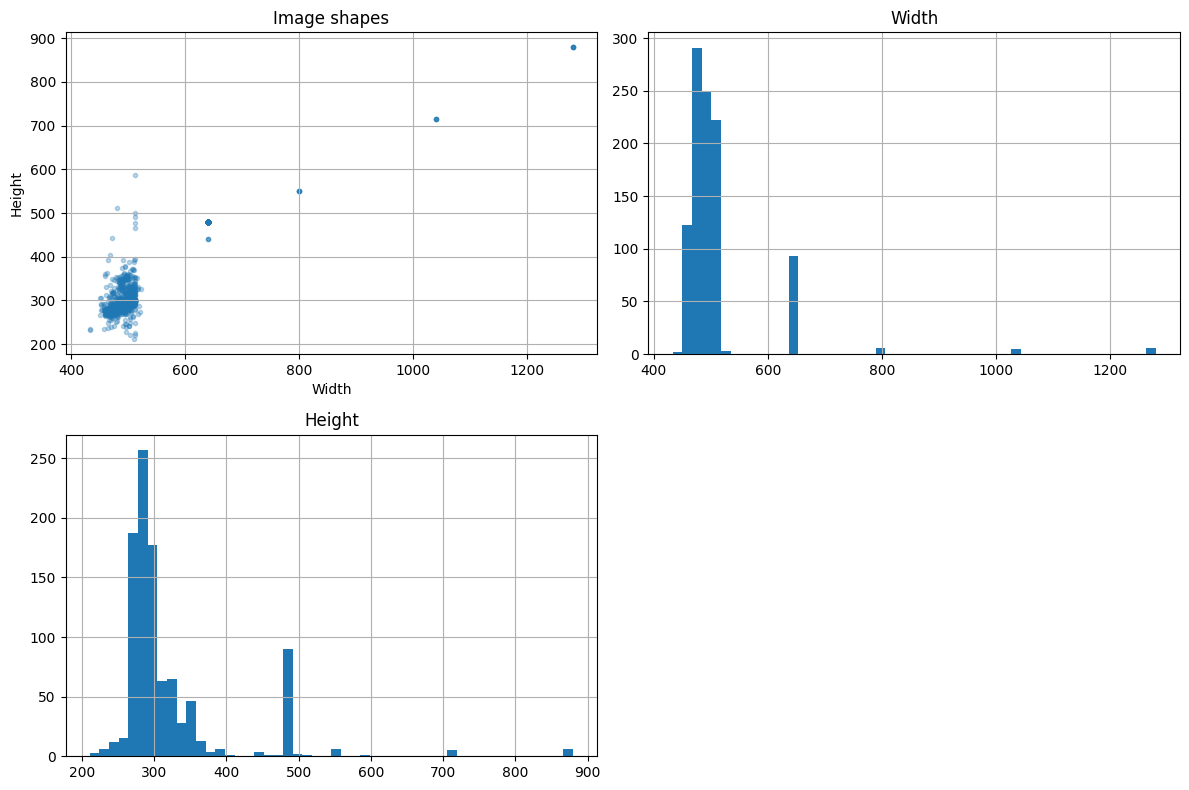

<IPython.core.display.Javascript object>

In [82]:
def visualize_image_stats(figsize=(12, 8)):
    image_shapes = [ai.image.shape for ai in DATA.annotated_images]

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=figsize)

    height, width, channel = zip(*image_shapes)

    IPython.display.display(
        pd.DataFrame(dict(width=width, height=height, channel=channel)).describe()
    )

    plt.sca(axes[0][0])
    plt.title("Image shapes")
    plt.xlabel("Width")
    plt.ylabel("Height")
    plt.scatter(
        width,
        height,
        marker=".",
        alpha=0.3,
    )
    plt.grid()

    plt.sca(axes[0][1])
    plt.title("Width")
    plt.hist(width, bins=50)
    plt.grid()

    plt.sca(axes[1][0])
    plt.title("Height")
    plt.hist(height, bins=50)
    plt.grid()

    plt.sca(axes[1][1])
    plt.axis("off")

    plt.tight_layout()


visualize_image_stats()

In [16]:
CONFIG.image_width = 720
CONFIG.image_height = 512

<IPython.core.display.Javascript object>

In [19]:
def plot_image_with_annotations(image_index, show_categorical_data=True):
    annotated_image = DATA.annotated_images[image_index]
    annotation = annotated_image.annotation
    image = annotated_image.image
    plt.subplots(figsize=(8, 6))
    plt.imshow(image)

    if show_categorical_data:
        IPython.display.display(
            pd.Series(
                dict(
                    source=annotation.source.value,
                    chart_type=annotation.chart_type.value,
                    x_values_type=annotation.axes.x_axis.values_type.value,
                    y_values_type=annotation.axes.y_axis.values_type.value,
                    x_tick_type=annotation.axes.x_axis.tick_type.value,
                    y_tick_type=annotation.axes.y_axis.tick_type.value,
                )
            )
        )

    plt.plot(*annotation.plot_bb.get_bounds(), c="red", label="bounding_box")

    plt.scatter(
        *list(zip(*[[tick.x, tick.y] for tick in annotation.axes.x_axis.ticks])),
        label="x_ticks"
    )
    plt.scatter(
        *list(zip(*[[tick.x, tick.y] for tick in annotation.axes.y_axis.ticks])),
        label="y_ticks"
    )

    text_role_colors = dict(zip(TextRole, plt.cm.Accent.colors))
    seen_roles = set()
    for i, text in enumerate(annotation.text):
        xs = [
            text.polygon.x0,
            text.polygon.x1,
            text.polygon.x2,
            text.polygon.x3,
            text.polygon.x0,
        ]
        ys = [
            text.polygon.y0,
            text.polygon.y1,
            text.polygon.y2,
            text.polygon.y3,
            text.polygon.y0,
        ]
        plt.plot(
            xs,
            ys,
            c=text_role_colors[text.role],
            label=text.role.value if text.role not in seen_roles else None,
        )
        seen_roles.add(text.role)

    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

<IPython.core.display.Javascript object>

source              generated
chart_type       vertical_bar
x_values_type     categorical
y_values_type       numerical
x_tick_type           markers
y_tick_type           markers
dtype: object

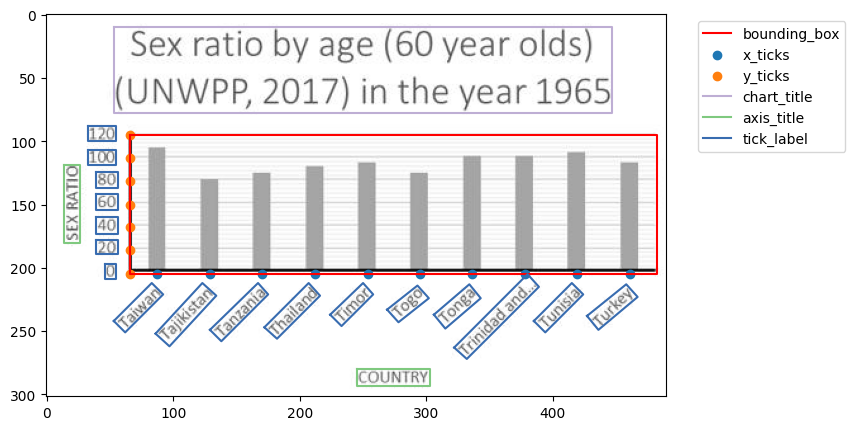

<IPython.core.display.Javascript object>

In [20]:
plot_image_with_annotations(np.random.choice(len(DATA.annotated_images)))

### Data splits <span id=Data_splits_></span>

In [99]:
def split_train_indices_by_source():
    extracted_image_indices = []
    generated_image_indices = []
    for i, annotated_image in enumerate(DATA.annotated_images):
        if annotated_image.annotation.source == Source.extracted:
            extracted_image_indices.append(i)
        else:
            generated_image_indices.append(i)
    return extracted_image_indices, generated_image_indices

<IPython.core.display.Javascript object>

In [135]:
def get_train_val_split_indices(val_fraction=0.1, seed=42):
    np.random.seed(42)
    val_size = int(len(load_train_image_ids()) * val_fraction)

    extracted_image_indices, generated_image_indices = split_train_indices_by_source()
    extracted_image_indices = np.random.permutation(extracted_image_indices)
    generated_image_indices = np.random.permutation(generated_image_indices)

    val_indices = extracted_image_indices[:val_size]
    n_generated_images_in_val = val_size - len(val_indices)
    val_indices = np.concatenate(
        [val_indices, generated_image_indices[:n_generated_images_in_val]]
    )

    train_indices = generated_image_indices[n_generated_images_in_val:]

    assert len(set(train_indices) | set(val_indices)) == len(load_train_image_ids())
    assert len(val_indices) == val_size
    assert len(set(train_indices) & set(val_indices)) == 0

    return train_indices, val_indices

<IPython.core.display.Javascript object>

In [136]:
CONFIG.val_fraction = 0.1
CONFIG.seed = 42
DATA.train_indices, DATA.val_indices = get_train_val_split_indices(
    CONFIG.val_fraction, CONFIG.seed
)

<IPython.core.display.Javascript object>

### Prediction target <span id=Prediction_target_></span>

In [130]:
pd.read_csv("data/sample_submission.csv").head(4)

,id,data_series,chart_type
0,000b92c3b098_x,abc;def,vertical_bar
1,000b92c3b098_y,0.0;1.0,vertical_bar
2,007a18eb4e09_x,abc;def,vertical_bar
3,007a18eb4e09_y,0.0;1.0,vertical_bar


<IPython.core.display.Javascript object>

In the Benetech competition I need to predict chart type and axis values, so I will create appropriate tokens and later add them to the transformer.

In [53]:
def to_token_str(value: str or enum.Enum):
    string = value.name if isinstance(value, enum.Enum) else value
    return f"<{string}>"


TOKEN.benetech_prompt = to_token_str("benetech_prompt")
TOKEN.benetech_prompt_end = to_token_str("/benetech_prompt")

for chart_type in ChartType:
    setattr(TOKEN, chart_type.name, to_token_str(chart_type))

for values_type in ValuesType:
    setattr(TOKEN, values_type.name, to_token_str(values_type))

TOKEN.x_start = to_token_str("x_start")
TOKEN.y_start = to_token_str("y_start")
TOKEN.value_separator = to_token_str(";")

<IPython.core.display.Javascript object>

In [54]:
CONFIG.float_scientific_notation_string_precision = 5


def convert_number_to_scientific_string(value: int or float) -> str:
    return f"{value:.{CONFIG.float_scientific_notation_string_precision}e}"


def convert_axis_data_to_string(
    axis_data: list[str or int or float], values_type: ValuesType
) -> str:
    formatted_axis_data = []
    for value in axis_data:
        if values_type == ValuesType.numerical:
            value = convert_number_to_scientific_string(value)
        formatted_axis_data.append(value)
    return TOKEN.value_separator.join(formatted_axis_data)


def convert_string_to_axis_data(string, values_type: ValuesType):
    data = string.split(TOKEN.value_separator)
    if values_type == ValuesType.numerical:
        data = [float(i) for i in data]
    return data


def get_annotation_ground_truth_str(annotation: Annotation):
    chart_type = to_token_str(annotation.chart_type)
    x_values_type = to_token_str(annotation.axes.x_axis.values_type)
    y_values_type = to_token_str(annotation.axes.y_axis.values_type)
    x_data = convert_axis_data_to_string(
        [dp.x for dp in annotation.data_series], annotation.axes.x_axis.values_type
    )
    y_data = convert_axis_data_to_string(
        [dp.y for dp in annotation.data_series], annotation.axes.y_axis.values_type
    )
    return (
        f"{TOKEN.benetech_prompt}{chart_type}"
        f"{TOKEN.x_start}{x_values_type}{x_data}"
        f"{TOKEN.y_start}{y_values_type}{y_data}"
        f"{TOKEN.benetech_prompt_end}"
    )

<IPython.core.display.Javascript object>

In [55]:
print(get_annotation_ground_truth_str(DATA.annotated_images[0].annotation))

<benetech_prompt><dot><x_start><categorical>1-10<;>11-20<;>21-30<;>31-40<;>41-50<;>51-52<y_start><numerical>1.00000e+00<;>3.00000e+00<;>7.00000e+00<;>2.00000e+00<;>8.00000e+00<;>4.00000e+00</benetech_prompt>


<IPython.core.display.Javascript object>

In [159]:
def compute_numeric_data_loss_due_to_string_conversion():
    squared_error = 0
    n_numeric_values = 0
    for annotated_image in DATA.annotated_images:
        annotation = annotated_image.annotation
        for axis, data in zip(
            [annotation.axes.x_axis, annotation.axes.y_axis],
            [
                [dp.x for dp in annotation.data_series],
                [dp.y for dp in annotation.data_series],
            ],
        ):
            if axis.values_type == ValuesType.numerical:
                string = convert_axis_data_to_string(data, ValuesType.numerical)
                reconverted_data = convert_string_to_axis_data(
                    string, ValuesType.numerical
                )
                squared_error += (
                    (np.array(data) - np.array(reconverted_data)) ** 2
                ).sum()
                n_numeric_values += len(data)

    mse = squared_error**0.5 / n_numeric_values
    return mse

<IPython.core.display.Javascript object>

In [160]:
print(compute_numeric_data_loss_due_to_string_conversion())

0.4810869511837585


<IPython.core.display.Javascript object>

### Dataset <span id=Dataset_></span>

In [258]:
@dataclasses.dataclass
class Dataitem:
    image: torch.FloatTensor
    target_string: str

    def __post_init__(self):
        if DEBUG:
            shape = einops.parse_shape(self.image, "channel height width")
            assert shape["channel"] == 3, "Image is expected to have 3 channels."


class Dataset(torch.utils.data.Dataset):
    def __init__(self, split: Literal["train", "val", "complete"]):
        super().__init__()
        match split:
            case "train":
                self.indices = DATA.train_indices
            case "val":
                self.indices = DATA.val_indices
            case "complete":
                self.indices = np.arange(len(DATA.annotated_images))
            case _:
                raise ValueError(f"Unknown split {split}.")
        self.to_tensor = torchvision.transforms.ToTensor()

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx: int) -> Dataitem:
        data_index = self.indices[idx]
        annotated_image = DATA.annotated_images[data_index]

        image = annotated_image.image
        image = self.to_tensor(image)

        target_string = get_annotation_ground_truth_str(annotated_image.annotation)

        return Dataitem(image=image, target_string=target_string)

<IPython.core.display.Javascript object>

In [178]:
DATA.train_dataset = Dataset("train")
DATA.val_dataset = Dataset("val")
DATA.complete_dataset = Dataset("complete")

<IPython.core.display.Javascript object>

<benetech_prompt><vertical_bar><x_start><categorical>Asia, Central<;>Australia<;>Australia & New Zealand<;>Austria<;>Azerbaijan<;>Bahamas<;>Bahrain<;>Bangladesh<;>Barbados<;>Belarus<y_start><numerical>5.90418e+06<;>2.21288e+06<;>4.33664e+06<;>8.17963e+06<;>8.58416e+06<;>6.35927e+06<;>7.87624e+06<;>8.93812e+06<;>5.29739e+06<;>8.48303e+06</benetech_prompt>


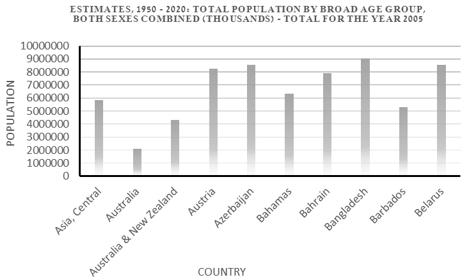

<IPython.core.display.Javascript object>

In [206]:
print(DATA.train_dataset[0].target_string)
torchvision.transforms.functional.to_pil_image(DATA.train_dataset[0].image)

## Model <span id=Model_></span>

In [59]:
CONFIG.pretrained_model_name = "naver-clova-ix/donut-base"
CONFIG.encoder_decoder_config = transformers.VisionEncoderDecoderConfig.from_pretrained(
    CONFIG.pretrained_model_name
)
CONFIG.encoder_decoder_config.encoder.image_size = (
    CONFIG.image_width,
    CONFIG.image_height,
)

MODEL.donut_processor = transformers.DonutProcessor.from_pretrained(
    CONFIG.pretrained_model_name
)
MODEL.donut_processor.image_processor.size = dict(
    width=CONFIG.image_width, height=CONFIG.image_height
)
MODEL.tokenizer = MODEL.donut_processor.tokenizer
MODEL.encoder_decoder = transformers.VisionEncoderDecoderModel.from_pretrained(
    CONFIG.pretrained_model_name, config=CONFIG.encoder_decoder_config
)

CONFIG.encoder_decoder_config.pad_token_id = MODEL.tokenizer.pad_token_id
CONFIG.encoder_decoder_config.decoder_start_token_id = (
    MODEL.tokenizer.convert_tokens_to_ids(TOKEN.benetech_prompt)
)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


<IPython.core.display.Javascript object>

### Add task specific tokens <span id=Add_task_specific_tokens_></span>

In [60]:
def add_unknown_tokens_to_tokenizer(unknown_tokens: list[str]):
    assert set(unknown_tokens) == set(unknown_tokens) - set(
        MODEL.tokenizer.vocab.keys()
    ), "Tokens are not unknown."

    MODEL.tokenizer.add_tokens(unknown_tokens)
    MODEL.encoder_decoder.decoder.resize_token_embeddings(len(MODEL.tokenizer))

<IPython.core.display.Javascript object>

In [61]:
add_unknown_tokens_to_tokenizer(list(TOKEN.__dict__.values()))

<IPython.core.display.Javascript object>

### Add dataset specific tokens <span id=Add_dataset_specific_tokens_></span>

In [62]:
def find_unknown_tokens_for_tokenizer() -> collections.Counter:
    unknown_tokens_counter = collections.Counter()

    for annotated_image in DATA.annotated_images:
        ground_truth = get_annotation_ground_truth_str(annotated_image.annotation)

        input_ids = MODEL.tokenizer(ground_truth).input_ids
        tokens = MODEL.tokenizer.tokenize(ground_truth, add_special_tokens=True)

        for token_id, token in zip(input_ids, tokens, strict=True):
            if token_id == MODEL.tokenizer.unk_token_id:
                unknown_tokens_counter.update([token])

    return unknown_tokens_counter

<IPython.core.display.Javascript object>

In [63]:
print(find_unknown_tokens_for_tokenizer())

Counter({'1': 4})


<IPython.core.display.Javascript object>

In [64]:
add_unknown_tokens_to_tokenizer(list(find_unknown_tokens_for_tokenizer().keys()))
print(find_unknown_tokens_for_tokenizer())

Counter()


<IPython.core.display.Javascript object>

In [197]:
def compute_target_tokens_length_distribution():
    token_lenghts = []
    for data_item in tqdm.autonotebook.tqdm(
        DATA.complete_dataset, desc="Encoding target strings"
    ):
        encoding = MODEL.tokenizer(data_item.target_string)
        token_lenghts.append(len(encoding.input_ids))
    return token_lenghts


def visualize_target_tokens_length_distribution():
    token_lenghts = compute_target_tokens_length_distribution()
    plt.hist(token_lenghts, bins=50)
    plt.title("Token length")
    series = pd.Series(token_lenghts, name="Token length").to_frame().describe()
    IPython.display.display(series)

<IPython.core.display.Javascript object>

Encoding target strings.:   0%|          | 0/1000 [00:00<?, ?it/s]

,Token length
count,1000.000000
mean,175.588000
std,104.350886
min,51.000000
25%,122.000000
50%,143.000000
75%,185.250000
max,1201.000000


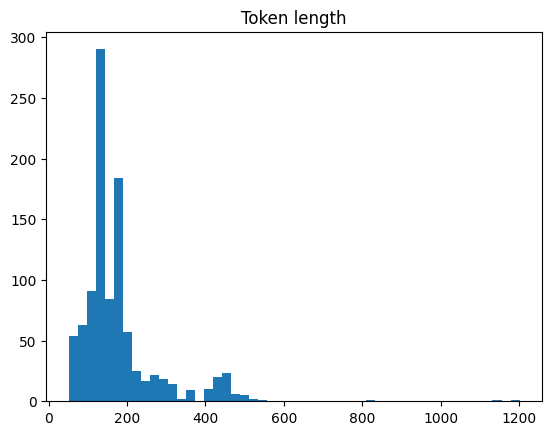

<IPython.core.display.Javascript object>

In [198]:
visualize_target_tokens_length_distribution()

In [201]:
CONFIG.encoder_decoder_config.decoder.max_length = 512

<IPython.core.display.Javascript object>

### Dataloader <span id=Dataloader_></span>

In [309]:
@dataclasses.dataclass
class Batch:
    images: torch.FloatTensor
    labels: torch.IntTensor

    def __post_init__(self):
        if DEBUG:
            images_shape = einops.parse_shape(self.images, "batch channel height width")
            labels_shape = einops.parse_shape(self.labels, "batch label")
            assert images_shape["batch"] == labels_shape["batch"]


def replace_pad_token_id_with_negative_hundred_for_hf_transformers_automatic_batch_transformation(
    token_ids,
):
    token_ids[token_ids == MODEL.tokenizer.pad_token_id] = -100
    return token_ids


def collate_function(batch: list[Dataitem], split: Literal["train", "val"]) -> Batch:
    images = [di.image for di in batch]
    images = MODEL.donut_processor(
        images, random_padding=split == "train", return_tensors="pt"
    ).pixel_values

    target_token_ids = MODEL.tokenizer(
        [di.target_string for di in batch],
        add_special_tokens=False,
        max_length=CONFIG.encoder_decoder_config.decoder.max_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt",
    ).input_ids
    labels = replace_pad_token_id_with_negative_hundred_for_hf_transformers_automatic_batch_transformation(
        target_token_ids
    )

    return Batch(images=images, labels=labels)


CONFIG.batch_size = 2 if DEBUG else 32
CONFIG.num_workers = 4


def build_dataloader(split: Literal["train", "val"]):
    return torch.utils.data.DataLoader(
        DATA.train_dataset if split == "train" else DATA.val_dataset,
        batch_size=CONFIG.batch_size,
        shuffle=split == "train",
        num_workers=CONFIG.num_workers,
        collate_fn=functools.partial(collate_function, split=split),
    )


DATA.train_dataloader = build_dataloader("train")
DATA.val_dataloader = build_dataloader("val")

<IPython.core.display.Javascript object>

### Lightning module <span id=Lightning_module_></span>

In [324]:
CONFIG.learning_rate = 1e-5


class LightningModule(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = MODEL.encoder_decoder

    def training_step(self, batch: Batch, batch_idx: int) -> torch.Tensor:
        outputs = self.model(pixel_values=batch.images, labels=batch.labels)
        loss = outputs.loss
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch: Batch, batch_idx: int, dataset_idx: int = 0):
        outputs = self.model(pixel_values=batch.images, labels=batch.labels)
        loss = outputs.loss
        self.log("val_loss", loss)

    def configure_optimizers(self) -> torch.optim.Optimizer:
        optimizer = torch.optim.Adam(self.parameters(), lr=CONFIG.learning_rate)
        return optimizer


MODEL.lightning_module = LightningModule()

<IPython.core.display.Javascript object>

## Training <span id=Training_></span>

In [325]:
CONFIG.device = "cpu"

trainer = pl.Trainer(accelerator=CONFIG.device)

trainer.fit(MODEL.lightning_module, train_dataloaders=DATA.train_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/home/dkkoshman/YSDA/python3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=6)`.
  rank_zero_warn(
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                      | Params
----------------------------------------------------
0 | model | VisionEncoderDecoderModel | 201 M 
----------------------------------------------------
201 M     Trainable params
0         Non-trainable params
201 M     Total params
807.465   Total estimated model params size (MB)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Training: 0it [00:00, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

/home/dkkoshman/YSDA/python3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:54: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


<IPython.core.display.Javascript object>

In [ ]:
metrics
checkpoint
wandb

## Results <span id=Results_></span>